In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

### Designing the Kalman Filter

Modelling as,

$$ X_{t+1} = A_{t}X_{t} + B_{t}U_{t} + \epsilon_{t} $$
$$ Z_t = C_{t}X_{t} + \delta_{t} $$

In [3]:
def parameters():
    A = np.identity(4)
    A[0,2], A[1,3] = 1,1                              # VERIFY THIS!!! (Time steps are not included!)

    B = np.array([[1/2,0],[0,1/2],[1,0],[0,1]])     # VERIFY THIS!!!  (Should be 1/2 * a * t^2 )

    meu_q = np.zeros((4))
    cov_q = np.identity(4)
    cov_q[2,2],cov_q[3,3] = 0.0001,0.0001
    # To genrate => ep = np.random.multivariate_normal(meu_q,cov_q,N)

    C = np.array([[1,0,0,0],[0,1,0,0]])
    meu_r = np.zeros((2))
    cov_r = 100*np.identity(2)
    # To genrate => ep = np.random.multivariate_normal(meu_r,cov_r,N)

    T = 200     # Total time steps
    
    return (A,B,meu_q,cov_q,C,meu_r,cov_r,T)

# A,B,meu_q,cov_q,C,meu_r,cov_r,T = parameters()
# params = parameters()

### 2. (a)  Simulate motion and sensor model, and plot the actual and observed trajectory.

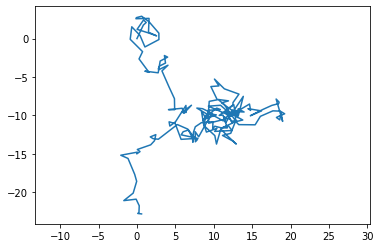

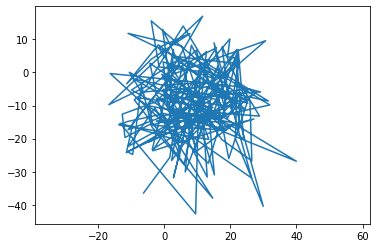

In [15]:
def zero_initializer():
    del_xy = np.zeros((2))
    X = np.zeros((4))
    return(del_xy,X)


def time_series(U, X_init , params):
    
    A,B,meu_q,cov_q,C,meu_r,cov_r,T = params

    # Assuming deltax and deltay are 0         # CAN/DO WE MAKE THIS ASSUMPTION
    del_xy = U
    
    ep_q = np.random.multivariate_normal(meu_q,cov_q)
    ep_r = np.random.multivariate_normal(meu_r,cov_r)
    
    X = np.zeros((T,4))
    X[0,:] = X_init
    X_obs = np.zeros((T,2))
    X_obs[0,:] = np.dot(C,X[0,:]) + ep_r
    
    
    
    X_obs[0,:] = np.random.multivariate_normal(meu_r,cov_r)


    for i in range(1,T):
        ep_q = np.random.multivariate_normal(meu_q,cov_q)
        X[i,:] = np.dot(A,X[i-1,:])+np.dot(B,del_xy) + ep_q

        ep_r = np.random.multivariate_normal(meu_r,cov_r)
        X_obs[i,:] = np.dot(C,X[i,:]) + ep_r
    
    return (X,X_obs)

def plotter(X):

    x, y = X[:,0],X[:,1]
    plt.plot(x, y)
    plt.axis('equal')
    plt.show()


params = parameters()
del_xy,X_init = zero_initializer()
X,X_obs = time_series(del_xy,X_init,params)
plotter(X)
plotter(X_obs)

### 2.(b) Estimation of Vehicle state
We use Kalman filter form of Baye's filter for the implementing the estimation of the vehicle's state.

As mentioned before, modelling as,

$$ X_{t+1} = A_{t}X_{t} + B_{t}U_{t} + \epsilon_{t} $$
$$ Z_t = C_{t}X_{t} + \delta_{t} $$

###### Dynamic Update:
$$ \bar{\mu} = A*X\_bel\_\mu_{i-1} + B*U $$
$$ \bar{\Sigma} = A*X\_bel\_\Sigma_{i-1}*A^{T} + Cov\_matrix(\epsilon_{t}) $$

###### Measurement Update:
$$ R = \bar{\Sigma}C^{T}(C\bar{\Sigma}C^{T}+R) + Cov\_matrix(\delta_{t})$$
$$ X\_bel\_\mu_{i} = \bar{\mu} + K(Z_{t}-C\bar{\mu}) $$
$$ X\_bel\_\Sigma_{i} = (I - KC)\bar{\Sigma} $$

In [31]:
params = parameters()
del_xy,X_init = zero_initializer()
X_init = np.array([10,10,1,1])
X,X_obs = time_series(del_xy,X_init,params)

In [34]:
def Kalman_Filter(meu_prev,cov_prev,U,Z,params):
    A,B,meu_q,cov_q,C,meu_r,cov_r,T = params
    # Dynamics Update:
    meu_temp = np.dot(A,meu_prev) + np.dot(B,U)
    cov_temp = np.dot(np.dot(A,cov_prev),A.T) + cov_q
    # Measurement Update:
    K = np.dot( np.dot( cov_temp,C.T ) , np.linalg.inv( np.dot(np.dot(C,cov_temp),C.T) + cov_r) )
    meu = meu_temp + np.dot(K,Z-np.dot(C,meu_temp))
    KC_calc = np.dot(K,C)
    cov = np.dot(np.identity(KC_calc.shape[0]) - KC_calc , cov_temp)
    
    return (meu,cov)
    
def state_estimation(U , X , X_obs , params):
    
    A,B,meu_q,cov_q,C,meu_r,cov_r,T = params
    
    X_init = X[0,:]
    X_belief_meu = np.zeros((T,X.shape[1]))
    X_belief_cov = np.zeros((T,X.shape[1],X.shape[1]))
    
    #X_belief_meu[0,:] = np.random.multivariate_normal(X_init , 0.0001*np.identity(4))
    X_belief_meu[0,:] = X_init
    X_belief_cov[0,:] = 0.0001*np.identity(X.shape[1])
    
    for i in range(1,T):
        X_belief_meu[i,:],X_belief_cov[i,:] = Kalman_Filter(X_belief_meu[i-1,:],
                                                            X_belief_cov[i-1,:],
                                                            U,X_obs[i-1],params)
        
    return (X_belief_meu,X_belief_cov)

X_pred_meu,X_pred_var = state_estimation(del_xy , X , X_obs , params)


### 2.(c) Plot the Actual Trajectory, Noisy Observations, Estimated Tragectory (produced by filter). Also plot, uncertainty ellipse for the estimated trajectory
An uncertainty ellipse denotes the locus of points that are one standard deviation away from the mean.

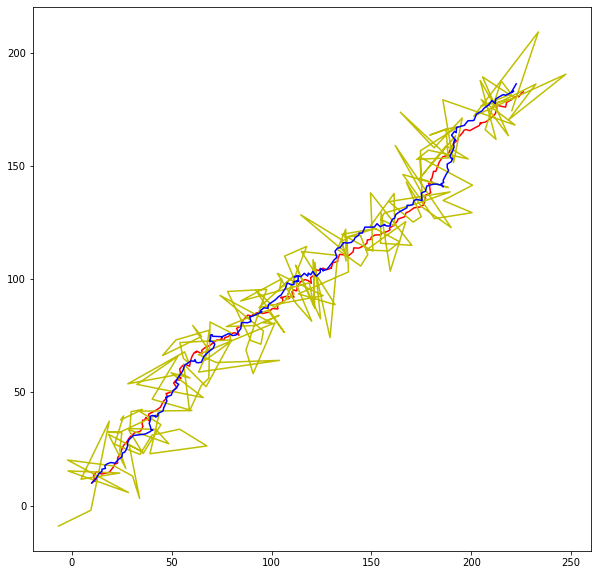

In [54]:
def uncertain_ellipse(X,X_obs,X_pred_meu,X_pred_var):
    

    
    
def multiplotter(X1,X2,X3):
    x1, y1 = X1[:,0],X1[:,1]
    x2, y2 = X2[:,0],X2[:,1]
    x3, y3 = X3[:,0],X3[:,1]
    plt.figure(figsize=(10, 10))
    plt.plot(x1, y1, color='r')
    plt.plot(x2, y2, color='y')
    plt.plot(x3, y3, color='b')
    #plt.axis('equal')
    plt.show()

multiplotter(X,X_obs,X_pred)